In [2]:
import yfinance as yf
import pandas as pd
import numpy as np

In [3]:

#SPY = yf.download('SPY', period="10y", interval="1d", multi_level_index=False)
SPY_options = yf.Ticker('SPY').options
SPY_options

# Build one DataFrame with all call chains and expiration stamped
calls_frames = []
for expiration_date in SPY_options:
    option_chain = yf.Ticker('SPY').option_chain(expiration_date)
    calls_df = option_chain.calls.copy()
    calls_df['expiration'] = expiration_date
    calls_frames.append(calls_df)

calls = pd.concat(calls_frames, ignore_index=True)
calls.head()

Strikes = np.arange(600, 800, 5)
df_strikes = calls[calls['strike'].isin(Strikes)]
df_strikes.head()

calls.to_csv('SPY_calls_all.csv', index=False)

calls.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,expiration
0,SPY251230C00500000,2025-12-29 16:17:29+00:00,500.0,187.36,186.31,188.98,0.0,0.0,35.0,35,3.015627,True,REGULAR,USD,2025-12-30
1,SPY251230C00510000,2025-12-23 20:28:52+00:00,510.0,178.12,176.27,178.98,0.0,0.0,NaN,7,2.839847,True,REGULAR,USD,2025-12-30
2,SPY251230C00520000,2025-12-23 19:37:45+00:00,520.0,168.07,166.27,168.96,0.0,0.0,NaN,5,2.673831,True,REGULAR,USD,2025-12-30
3,SPY251230C00540000,2025-12-17 16:52:55+00:00,540.0,133.30,146.23,149.02,0.0,0.0,NaN,0,2.363285,True,REGULAR,USD,2025-12-30
4,SPY251230C00545000,2025-12-17 16:13:00+00:00,545.0,129.11,141.20,143.98,0.0,0.0,NaN,0,2.267582,True,REGULAR,USD,2025-12-30


In [28]:
#Strikes = np.arange(600, 800, 5)
Strikes = pd.DataFrame(Strikes, columns=['strike'])
Strikes


,strike
0,500.0
1,510.0
2,520.0
3,540.0
4,545.0
...,...
412,140.0
413,195.0
414,1015.0
415,1350.0


In [31]:

Time_To_Expiration = pd.to_datetime(calls['expiration'] + ' 16:00:00') - pd.to_datetime('today')
Time_To_Expiration = Time_To_Expiration.dt.days/365.0
Time_To_Expiration

Implied_Volatility = calls['impliedVolatility']
#Implied_Volatility


0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
4007    2.463014
4008    2.463014
4009    2.463014
4010    2.463014
4011    2.463014
Name: expiration, Length: 4012, dtype: float64

In [ ]:
import plotly.express as px

plot_df = calls[['strike', 'expiration', 'impliedVolatility']].copy()
plot_df['time_to_expiration'] = (
    pd.to_datetime(plot_df['expiration'] + ' 16:00:00') - pd.to_datetime('today') # add 4PM ET to expiration
).dt.days / 365.0
plot_df = plot_df.dropna(subset=['strike', 'time_to_expiration', 'impliedVolatility']) # subset dataframe

fig = px.scatter_3d(
    plot_df,
    x='strike',
    y='time_to_expiration',
    z='impliedVolatility',
    color='impliedVolatility',
    color_continuous_scale='Viridis',
    title='SPY Calls: Implied Volatility Surface'
)
fig.update_traces(marker=dict(size=2))
fig.update_layout(scene=dict(
    xaxis_title='Strike',
    yaxis_title='Time to Expiration (years)',
    zaxis_title='Implied Volatility'
))
fig.show()


In [89]:
import plotly.graph_objects as go

surface_df = calls[['strike', 'expiration', 'impliedVolatility']].copy()
surface_df['time_to_expiration'] = (
    pd.to_datetime(surface_df['expiration'] + ' 16:00:00') - pd.to_datetime('today')
).dt.days / 365.0
surface_df = surface_df.dropna(subset=['strike', 'time_to_expiration', 'impliedVolatility'])

surface_pivot = surface_df.pivot_table(
    index='strike', # x
    columns='time_to_expiration', # y
    values='impliedVolatility', # z
    aggfunc='mean'
)
surface_pivot = surface_pivot.sort_index().sort_index(axis=1)

# Fill NaNs to snap vertices together
z_grid = surface_pivot.to_numpy()
z_filled = np.nan_to_num(z_grid, nan=np.nanmean(z_grid))

x_grid = np.tile(surface_pivot.index.to_numpy().reshape(-1, 1), (1, surface_pivot.shape[1]))
y_grid = np.tile(surface_pivot.columns.to_numpy(), (surface_pivot.shape[0], 1))

fig = go.Figure(data=[go.Surface(x=x_grid, y=y_grid, z=z_filled, colorscale='Viridis')])
fig.update_layout(
    title='SPY Calls: Implied Volatility Surface',
    scene=dict(
        xaxis_title='Strike',
        yaxis_title='Time to Expiration (years)',
        zaxis_title='Implied Volatility',
        xaxis=dict(range=[400, 800]),  # STRIKE
        yaxis=dict(range=[0, 0.05]),   # TIME TO EXPIRATION
        zaxis=dict(range=[0, 5])        # IV
    )
)
fig.show()


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy.ma as ma

mat_df = calls[['strike', 'expiration', 'impliedVolatility']].copy()
mat_df['time_to_expiration'] = (
    pd.to_datetime(mat_df['expiration'] + ' 16:00:00') - pd.to_datetime('today')
).dt.days / 365.0
mat_df = mat_df.dropna(subset=['strike', 'time_to_expiration', 'impliedVolatility'])

mat_pivot = mat_df.pivot_table(
    index='strike',
    columns='time_to_expiration',
    values='impliedVolatility',
    aggfunc='mean'
)
mat_pivot = mat_pivot.sort_index().sort_index(axis=1)

x_vals = mat_pivot.index.to_numpy()
y_vals = mat_pivot.columns.to_numpy()
X, Y = np.meshgrid(y_vals, x_vals)
Z = mat_pivot.to_numpy()
Z_filled = np.nan_to_num(Z, nan=np.nanmean(Z))

12093

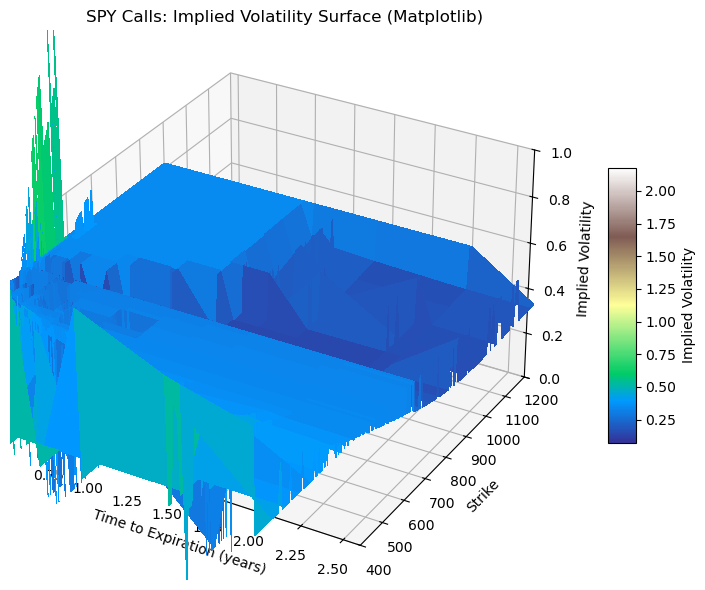

In [73]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z_filled, cmap=cm.terrain, linewidth=0, antialiased=False)
ax.set_xlabel('Time to Expiration (years)')
ax.set_ylabel('Strike')
ax.set_zlabel('Implied Volatility')
ax.set_title('SPY Calls: Implied Volatility Surface (Matplotlib)')
ax.set_xlim(0.7, 2.6) # TIME TO EXPIRATION
ax.set_ylim(400, 1200) # STRIKE
ax.set_zlim(0, 1) # IV
fig.colorbar(surf, shrink=0.5, aspect=10, label='Implied Volatility')
plt.tight_layout()
plt.show()


In [ ]:
np.arange(-5,5,0.25)
# I need to convert the times to expiry into an array
# I need to convert the strikes into an array of equal size

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

[[0.14684655 0.66876054 0.16883013 0.49301682 0.68541056 0.08185582
  0.4946085  0.90852179 0.21336131 0.32844953]
 [0.55651794 0.7195312  0.36037018 0.53859473 0.18952357 0.70089692
  0.42709231 0.28265688 0.28709104 0.24290134]
 [0.21776379 0.35681449 0.52952084 0.46562986 0.7069396  0.76996929
  0.75806171 0.35886612 0.75792281 0.80116341]
 [0.97624907 0.56306287 0.0763266  0.8000821  0.29551187 0.23686809
  0.51783929 0.80960364 0.1126396  0.96000104]
 [0.79465675 0.04522199 0.68674279 0.41754622 0.17886262 0.89230308
  0.31691044 0.07022219 0.08505688 0.81164446]
 [0.99152999 0.66273094 0.06071623 0.62270376 0.83157192 0.50155572
  0.46010658 0.39620888 0.42395581 0.63214848]
 [0.403151   0.36454756 0.8377877  0.89316374 0.34286127 0.22204381
  0.35396991 0.51264436 0.7549267  0.80990483]
 [0.0263071  0.82897736 0.31787434 0.77617238 0.08023389 0.27095334
  0.27027446 0.43959602 0.85443068 0.92497495]
 [0.00804567 0.5457647  0.62230735 0.78018023 0.02257345 0.62164423
  0.69844363

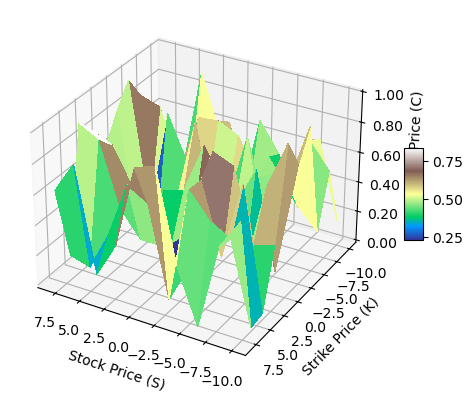

In [192]:

# X = Moneyess (%)
# Y = Time to Maturity (Years)
# Z = Call Option Price

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

X = np.arange(-10,10,2)
Y = np.arange(-10,10,2)

X, Y = np.meshgrid(X, Y)

def randy(x, y):
    return np.random.rand()

r_vector = np.vectorize(randy)
Z = r_vector(X, Y)
print(Z)


# Vectorize the C function to handle arrays



surf = ax.plot_surface(X, Y, Z, cmap=cm.terrain,
                       linewidth=0, antialiased=False)

# Customize the z-axis appearance and scale
#ax.set_zlim(-1.01, 1.01)  # Set the z-axis limits
#ax.zaxis.set_major_locator(LinearLocator(10))  # Display 10 major tick marks on z-axis
# Format the z-axis tick labels to 2 decimal places
ax.zaxis.set_major_formatter('{x:.02f}')
ax.set_xlabel('Stock Price (S)')
ax.set_ylabel('Strike Price (K)')
ax.set_zlabel('Call Option Price (C)')
ax.view_init(elev=30, azim=120)
# Add a color bar to the plot to show the mapping of colors to Z values
fig.colorbar(surf, shrink=0.25, aspect=5)

# Display the plot
plt.show()


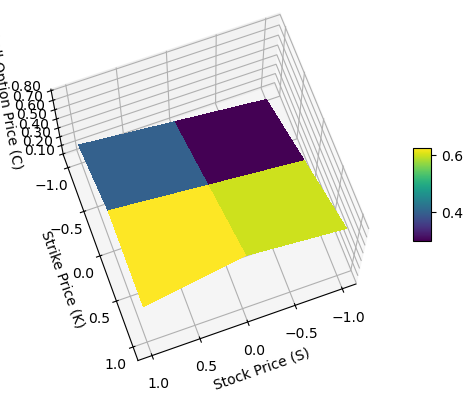

In [185]:

# X = Moneyess (%)
# Y = Time to Maturity (Years)
# Z = Call Option Price

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

n_x = 10
n_y = 10
X = np.array([-1,0,1])
Y = np.array([-1,0,1])
Z = np.array([[0.1, 0.2, 0.3],
              [0.4, 0.5, 0.6],
              [0.7, 0.8, 0.6]])
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis,
                       linewidth=0, antialiased=False)

# Customize the z-axis appearance and scale
#ax.set_zlim(-1.01, 1.01)  # Set the z-axis limits
#ax.zaxis.set_major_locator(LinearLocator(10))  # Display 10 major tick marks on z-axis
# Format the z-axis tick labels to 2 decimal places
ax.zaxis.set_major_formatter('{x:.02f}')
ax.set_xlabel('Stock Price (S)')
ax.set_ylabel('Strike Price (K)')
ax.set_zlabel('Call Option Price (C)')
ax.view_init(elev=70, azim=70)
# Add a color bar to the plot to show the mapping of colors to Z values
fig.colorbar(surf, shrink=0.25, aspect=5)

# Display the plot
plt.show()
